In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#dir_ = 'C:/Users/yeonjun.in/Desktop/SUBMISSION MODEL/' # input only here
dir_ = '/content/gdrive/My Drive/data/'

In [ ]:
raw_data_dir = dir_
processed_data_dir = dir_+'/processed_data/'

# 1. Main setup

In [ ]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [ ]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [ ]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [ ]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1941         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

# 2. Part 1
- Melting train data => grid_part_1
- creating price features => grid_part_2
- creating calendar features => grid_part_3

In [ ]:
########################### Load Data
#################################################################################
print('Load Main Data')

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv(raw_data_dir+'sales_train_evaluation.csv')
prices_df = pd.read_csv(raw_data_dir+'sell_prices.csv')
calendar_df = pd.read_csv(raw_data_dir+'calendar.csv')

Load Main Data


In [ ]:
########################### Make Grid
#################################################################################
print('Create Grid')

# We can tranform horizontal representation representation 바꾸기
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# If we look on train_df we see that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df), len(grid_df))

Create Grid
Train rows: 30490 59181090


In [ ]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [ ]:
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [ ]:
grid_df['sales'].unique()

array([  0,  12,   2,   4,   5,   9,   3,   1,  25,  45,  10,   8,   7,
        16,  54,   6,  50,  14,  11,  17,  15,  23,  13,  20,  19,  38,
        32,  21,  30,  33, 107,  51,  26, 147,  22,  43,  24,  35,  27,
        42,  49,  36,  18,  37, 116,  56,  28,  34,  41,  31,  39,  44,
       108,  55, 360,  62,  69,  75, 125,  53,  47,  29, 164,  52, 102,
        63,  98,  59, 203, 152,  65, 115,  46,  57,  90,  58,  78,  64,
       130,  60, 208,  93,  61,  40,  73, 182, 198, 121, 132, 436, 123,
       215, 160,  85, 112, 141,  79,  48, 153, 204,  70,  67,  92,  86,
       207,  74,  94,  66,  91, 128,  84,  71,  83,  72, 119,  76,  99,
       134,  80,  89, 106, 120, 323, 127, 139, 109, 140, 114, 296, 314,
       159,  96,  82,  81, 180, 137, 171, 100, 279, 316, 150,  97, 169,
        68,  87, 174, 188, 195, 124, 202, 175, 370, 118, 200, 136, 187,
       250, 104, 367, 178,  95,  88, 214, 186, 385, 105,  77, 177, 184,
       162, 103, 228, 331, 353, 101, 154, 126, 258, 117, 151, 16

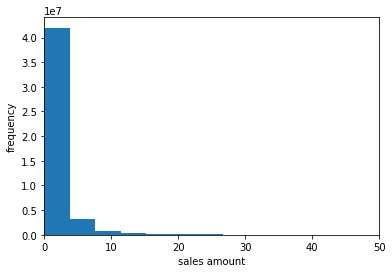

In [ ]:
import matplotlib.pyplot as plt

grid_dfx = pd.read_pickle(processed_data_dir+'lags_df_28.pkl')
plt.hist(grid_dfx['sales'],bins=200)
plt.xlabel('sales amount')
plt.ylabel('frequency')
plt.xlim([0,50])
plt.show()

In [ ]:
########################### Make Grid
#################################################################################
print('Create Grid')

# We can tranform horizontal representation representation 바꾸기
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# If we look on train_df we see that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df), len(grid_df))

# To be able to make predictions
# we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df
# anymore and can remove it
del train_df

# You don't have to use df = df construction
# you can use inplace=True instead.
# like this
# grid_df.reset_index(drop=True, inplace=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Create Grid
Train rows: 30490 59181090
    Original grid_df:   3.6GiB
     Reduced grid_df:   1.3GiB


In [ ]:
########################### Product Release date
#################################################################################
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# absence for the item in the store
# we can safe some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']

# Now we can merge release_df
grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
del release_df

# We want to remove some "zeros" rows
# from grid_df 
# to do it we need wm_yr_wk column
# let's merge partly calendar_df to have it
grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])
                      
# Now we can cutoff some rows 
# and safe memory 
grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# Should we keep release week 
# as one of the features?
# Only good CV can give the answer.
# Let's minify the release values.
# Min transformation will not help here 
# as int16 -> Integer (-32768 to 32767)
# and our grid_df['release'].max() serves for int16
# but we have have an idea how to transform 
# other columns in case we will need it
grid_df['release'] = grid_df['release'] - grid_df['release'].min()
grid_df['release'] = grid_df['release'].astype(np.int16)

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

Release week
    Original grid_df:   1.8GiB
     Reduced grid_df:   1.5GiB


In [ ]:
########################### Save part 1
#################################################################################
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
grid_df.to_pickle(processed_data_dir+'grid_part_1.pkl')

print('Size:', grid_df.shape)

Save Part 1
Size: (47735397, 10)


In [ ]:
########################### Prices
#################################################################################
print('Prices')

# We can do some basic aggregations
prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# and do price normalization (min/max scaling)
prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

# Some items are can be inflation dependent
# and some items are very "stable"

prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique') 
prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

# I would like some "rolling" aggregations
# but would like months and years as "window"
calendar_prices = calendar_df[['wm_yr_wk','month','year']]
calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk']) # distinct(.keep_all = True)
prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
del calendar_prices

# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

del prices_df['month'], prices_df['year']

Prices


In [ ]:
grid_df = reduce_mem_usage(grid_df)
prices_df = reduce_mem_usage(prices_df)

Mem. usage decreased to 1003.11 Mb (35.3% reduction)
Mem. usage decreased to 306.64 Mb (60.8% reduction)


In [ ]:
########################### Merge prices and save part 2
#################################################################################
print('Merge prices and save part 2')

# Merge Prices
original_columns = list(grid_df)
grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(grid_df) if col not in original_columns]
grid_df = grid_df[MAIN_INDEX+keep_columns]
grid_df = reduce_mem_usage(grid_df)

# Safe part 2
grid_df.to_pickle(processed_data_dir+'grid_part_2.pkl')
print('Size:', grid_df.shape)

grid_df.head()

Merge prices and save part 2
Mem. usage decreased to 1776.92 Mb (0.0% reduction)
Size: (47735397, 13)


,id,d,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,HOBBIES_1_008_CA_1_evaluation,d_1,0.459961,0.500000,0.419922,0.019760,0.476318,0.919922,4,16,NaN,0.968750,0.949219
1,HOBBIES_1_009_CA_1_evaluation,d_1,1.559570,1.769531,1.559570,0.032745,1.764648,0.881348,2,9,NaN,0.885742,0.896484
2,HOBBIES_1_010_CA_1_evaluation,d_1,3.169922,3.169922,2.970703,0.046356,2.980469,1.000000,2,20,NaN,1.064453,1.043945
3,HOBBIES_1_012_CA_1_evaluation,d_1,5.980469,6.519531,5.980469,0.115967,6.468750,0.916992,3,71,NaN,0.921875,0.958984
4,HOBBIES_1_015_CA_1_evaluation,d_1,0.700195,0.720215,0.680176,0.011337,0.706543,0.972168,3,16,NaN,0.990234,1.001953


In [ ]:
# We don't need prices_df anymore
del prices_df, grid_df

# We can remove new columns
# or just load part_1
grid_df = pd.read_pickle(processed_data_dir+'grid_part_1.pkl')

In [ ]:
########################### Merge calendar
#################################################################################
grid_df = grid_df[MAIN_INDEX]

# Merge calendar partly
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']

grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

# Minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']
for col in icols:
    grid_df[col] = grid_df[col].astype('category')

# Convert to DateTime
grid_df['date'] = pd.to_datetime(grid_df['date'])

# Make some features from date
grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
grid_df['tm_y'] = grid_df['date'].dt.year
grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8) # 2011 -> 0
grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8) # 오늘 몇째주?

grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8) 
grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

# Remove date
del grid_df['date']

In [ ]:
########################### Save part 3 (Dates)
#################################################################################
print('Save part 3')

# Safe part 3
grid_df.to_pickle(processed_data_dir+'grid_part_3.pkl')
print('Size:', grid_df.shape)

# We don't need calendar_df anymore
del calendar_df
del grid_df

Save part 3
Size: (47735397, 16)


In [ ]:
########################### Some additional cleaning
#################################################################################

## Part 1
# Convert 'd' to int
grid_df = pd.read_pickle(processed_data_dir+'grid_part_1.pkl')
grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)

# Remove 'wm_yr_wk'
# as test values are not in train set
del grid_df['wm_yr_wk']
grid_df.to_pickle(processed_data_dir+'grid_part_1.pkl')

del grid_df

# 3. Part2
- Lag featrue
- Lag rolling feature

In [ ]:
grid_df = pd.read_pickle(processed_data_dir+'grid_part_1.pkl')

# We need only 'id','d','sales'
# to make lags and rollings
grid_df = grid_df[['id','d','sales']]
SHIFT_DAY = 28

# Lags
# with 28 day shift
start_time = time.time()
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,30,60,180]:
    print('Rolling period:', i)
    grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create lags
296.77 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60
Rolling period: 180
Shifting period: 1
Shifting period: 7
Shifting period: 14
486.67 min: Lags


In [ ]:
########################### Export
#################################################################################
print('Save lags and rollings')
grid_df.to_pickle(processed_data_dir+'lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


# 4. Part3
- Mean encoding feature

In [ ]:
########################### Apply on grid_df
#################################################################################
# lets read grid from 
# https://www.kaggle.com/kyakovlev/m5-simple-fe
# to be sure that our grids are aligned by index
grid_df = pd.read_pickle(processed_data_dir+'grid_part_1.pkl')
grid_df['sales'][grid_df['d']>(1941-28)] = np.nan
base_cols = list(grid_df)

icols =  [
            ['state_id'],
            ['store_id'],
            ['cat_id'],
            ['dept_id'],
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
            ]
#icols = [['item_id', 'cat_id'],['item_id', 'dept_id'],['cat_id', 'dept_id'],['item_id', 'dept_id'],['item_id', 'dept_id','cat_id']]

for col in icols:
    print('Encoding', col)
    col_name = '_'+'_'.join(col)+'_'
    grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)['sales'].transform('mean').astype(np.float16)
    grid_df['enc'+col_name+'std'] = grid_df.groupby(col)['sales'].transform('std').astype(np.float16)

keep_cols = [col for col in list(grid_df) if col not in base_cols]
grid_df = grid_df[['id','d']+keep_cols]

#################################################################################
print('Save Mean/Std encoding')
grid_df.to_pickle(processed_data_dir+'mean_encoding_df.pkl')
#grid_df.to_pickle(processed_data_dir+'mean_encoding_df_test.pkl')

Encoding ['item_id', 'cat_id']
Encoding ['item_id', 'dept_id']
Encoding ['cat_id', 'dept_id']
Encoding ['item_id', 'dept_id']
Encoding ['item_id', 'dept_id', 'cat_id']
Save Mean/Std encoding


In [ ]:
test_df = pd.read_pickle(processed_data_dir+'mean_encoding_df.pkl')
test_df.head()

,id,d,enc_state_id_mean,enc_state_id_std,enc_store_id_mean,enc_store_id_std,enc_cat_id_mean,enc_cat_id_std,enc_dept_id_mean,enc_dept_id_std,enc_state_id_cat_id_mean,enc_state_id_cat_id_std,enc_state_id_dept_id_mean,enc_state_id_dept_id_std,enc_store_id_cat_id_mean,enc_store_id_cat_id_std,enc_store_id_dept_id_mean,enc_store_id_dept_id_std,enc_item_id_mean,enc_item_id_std,enc_item_id_state_id_mean,enc_item_id_state_id_std,enc_item_id_store_id_mean,enc_item_id_store_id_std
0,HOBBIES_1_008_CA_1_evaluation,1,1.574219,4.589844,1.636719,4.460938,0.708496,2.255859,0.865234,2.541016,0.88623,2.802734,1.100586,3.171875,1.003906,3.121094,1.260742,3.541016,4.687500,7.160156,6.582031,8.765625,7.230469,9.117188
1,HOBBIES_1_009_CA_1_evaluation,1,1.574219,4.589844,1.636719,4.460938,0.708496,2.255859,0.865234,2.541016,0.88623,2.802734,1.100586,3.171875,1.003906,3.121094,1.260742,3.541016,0.850098,1.752930,1.135742,2.099609,1.186523,2.015625
2,HOBBIES_1_010_CA_1_evaluation,1,1.574219,4.589844,1.636719,4.460938,0.708496,2.255859,0.865234,2.541016,0.88623,2.802734,1.100586,3.171875,1.003906,3.121094,1.260742,3.541016,0.610840,0.861816,0.562012,0.827148,0.719238,0.921875
3,HOBBIES_1_012_CA_1_evaluation,1,1.574219,4.589844,1.636719,4.460938,0.708496,2.255859,0.865234,2.541016,0.88623,2.802734,1.100586,3.171875,1.003906,3.121094,1.260742,3.541016,0.383057,0.690430,0.425781,0.726074,0.394043,0.649414
4,HOBBIES_1_015_CA_1_evaluation,1,1.574219,4.589844,1.636719,4.460938,0.708496,2.255859,0.865234,2.541016,0.88623,2.802734,1.100586,3.171875,1.003906,3.121094,1.260742,3.541016,4.425781,6.679688,6.921875,8.359375,6.066406,7.351562


In [ ]:
list(test_df)

['id',
 'd',
 'enc_state_id_mean',
 'enc_state_id_std',
 'enc_store_id_mean',
 'enc_store_id_std',
 'enc_cat_id_mean',
 'enc_cat_id_std',
 'enc_dept_id_mean',
 'enc_dept_id_std',
 'enc_state_id_cat_id_mean',
 'enc_state_id_cat_id_std',
 'enc_state_id_dept_id_mean',
 'enc_state_id_dept_id_std',
 'enc_store_id_cat_id_mean',
 'enc_store_id_cat_id_std',
 'enc_store_id_dept_id_mean',
 'enc_store_id_dept_id_std',
 'enc_item_id_mean',
 'enc_item_id_std',
 'enc_item_id_state_id_mean',
 'enc_item_id_state_id_std',
 'enc_item_id_store_id_mean',
 'enc_item_id_store_id_std']

In [ ]:
test2_df = pd.read_pickle(processed_data_dir+'lags_df_28.pkl')
test2_df.head()

,id,d,sales,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,sales_lag_35,sales_lag_36,sales_lag_37,sales_lag_38,sales_lag_39,sales_lag_40,sales_lag_41,sales_lag_42,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_tmp_1_7,rolling_mean_tmp_1_14,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60
0,HOBBIES_1_008_CA_1_evaluation,1,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_009_CA_1_evaluation,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_010_CA_1_evaluation,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_012_CA_1_evaluation,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_015_CA_1_evaluation,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
list(test2_df)

['id',
 'd',
 'sales',
 'sales_lag_28',
 'sales_lag_29',
 'sales_lag_30',
 'sales_lag_31',
 'sales_lag_32',
 'sales_lag_33',
 'sales_lag_34',
 'sales_lag_35',
 'sales_lag_36',
 'sales_lag_37',
 'sales_lag_38',
 'sales_lag_39',
 'sales_lag_40',
 'sales_lag_41',
 'sales_lag_42',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_30',
 'rolling_std_30',
 'rolling_mean_60',
 'rolling_std_60',
 'rolling_mean_180',
 'rolling_std_180',
 'rolling_mean_tmp_1_7',
 'rolling_mean_tmp_1_14',
 'rolling_mean_tmp_1_30',
 'rolling_mean_tmp_1_60',
 'rolling_mean_tmp_7_7',
 'rolling_mean_tmp_7_14',
 'rolling_mean_tmp_7_30',
 'rolling_mean_tmp_7_60',
 'rolling_mean_tmp_14_7',
 'rolling_mean_tmp_14_14',
 'rolling_mean_tmp_14_30',
 'rolling_mean_tmp_14_60']

In [ ]:
test3_df = pd.read_pickle(processed_data_dir+'grid_part_1.pkl')
test3_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12.0,0,11101
1,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2.0,0,11101
2,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
3,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,0,11101
4,HOBBIES_1_015_CA_1_evaluation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_1,4.0,0,11101


In [ ]:
list(test3_df)

['id',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'd',
 'sales',
 'release',
 'wm_yr_wk']

In [ ]:
test4_df = pd.read_pickle(processed_data_dir+'grid_part_2.pkl')
test4_df.head()

,id,d,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,HOBBIES_1_008_CA_1_evaluation,d_1,0.459961,0.500000,0.419922,0.019760,0.476318,0.919922,4,16,NaN,0.968750,0.949219
1,HOBBIES_1_009_CA_1_evaluation,d_1,1.559570,1.769531,1.559570,0.032745,1.764648,0.881348,2,9,NaN,0.885742,0.896484
2,HOBBIES_1_010_CA_1_evaluation,d_1,3.169922,3.169922,2.970703,0.046356,2.980469,1.000000,2,20,NaN,1.064453,1.043945
3,HOBBIES_1_012_CA_1_evaluation,d_1,5.980469,6.519531,5.980469,0.115967,6.468750,0.916992,3,71,NaN,0.921875,0.958984
4,HOBBIES_1_015_CA_1_evaluation,d_1,0.700195,0.720215,0.680176,0.011337,0.706543,0.972168,3,16,NaN,0.990234,1.001953


In [ ]:
list(test4_df)

['id',
 'd',
 'sell_price',
 'price_max',
 'price_min',
 'price_std',
 'price_mean',
 'price_norm',
 'price_nunique',
 'item_nunique',
 'price_momentum',
 'price_momentum_m',
 'price_momentum_y']

In [ ]:
test5_df = pd.read_pickle(processed_data_dir+'grid_part_3.pkl')
test5_df.head()

,id,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,tm_d,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,HOBBIES_1_008_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
1,HOBBIES_1_009_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
2,HOBBIES_1_010_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
3,HOBBIES_1_012_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
4,HOBBIES_1_015_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1


In [ ]:
list(test5_df)

['id',
 'd',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'tm_d',
 'tm_w',
 'tm_m',
 'tm_y',
 'tm_wm',
 'tm_dw',
 'tm_w_end']